<a href="https://colab.research.google.com/github/abdouramandalil/abdouramandalil/blob/main/Tensorflow_serving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1-Install Dependencies**

In [5]:
!echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0   169k      0 --:--:-- --:--:-- --:--:--  169k
OK


# 2-Install Tensorflow server

In [9]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 47 not upgraded.
Need to get 326 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.5.1 [326 MB]
Fetched 326 MB in 4s (80.2 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.5.1_all.deb ...
Unpacking tensorflow-model-server (2.5.1) ...
Setting up tensorflow-model-server (2.5.1) ...


In [10]:
!pip install requests

# 3-Install Libraries

In [11]:
import os
import json
import random
import requests
import subprocess
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
%matplotlib inline
tf.__version__

'1.14.0'

# **4-Import dataset**

In [12]:
(X_train,y_train),(X_test,y_test)=cifar10.load_data()

In [13]:
class_names=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

# **5-Normalize the images**

In [14]:
X_train=X_train/255.0
X_test=X_test/255.0

In [15]:
X_train.shape

(50000, 32, 32, 3)

In [16]:
X_test.shape

(10000, 32, 32, 3)

# **6-CNN Model Building**

In [17]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[32, 32, 3]))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


# **7-Compile the model**

In [18]:
model.compile(optimizer='Adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['sparse_categorical_accuracy'])

# **8-Train the model**

In [20]:
model.fit(X_train, 
          y_train, 
          batch_size=128, 
          epochs=3)

Epoch 1/3
50000/50000 [==============================] - 191s 4ms/sample - loss: 1.2758 - sparse_categorical_accuracy: 0.5473
Epoch 2/3
50000/50000 [==============================] - 188s 4ms/sample - loss: 0.9789 - sparse_categorical_accuracy: 0.6580
Epoch 3/3
50000/50000 [==============================] - 188s 4ms/sample - loss: 0.8271 - sparse_categorical_accuracy: 0.7109


# **9-Evaluate the model**

In [21]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

10000/10000 [==============================] - 10s 974us/sample - loss: 0.8591 - sparse_categorical_accuracy: 0.7000


In [22]:
print("Test accuracy is {}".format(test_accuracy))

Test accuracy is 0.699999988079071


In [23]:
MODEL_DIR="model/"
version = 1

# **10-Create directory for the model**

In [24]:
export_path=os.path.join(MODEL_DIR,str(version))
export_path

'model/1'

In [25]:
if os.path.isdir(export_path):
  !rm -r {export_path}

# **11-Save the model for Tensorflow serving**

In [27]:

tf.saved_model.simple_save(tf.keras.backend.get_session(),export_dir=export_path,inputs={"input_image":model.input},outputs={t.name:t for t in model.outputs})

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: model/1/saved_model.pb


# **12-Export the MODEL DIR to environnment variables**

In [28]:
os.environ["MODEL_DIR"]=os.path.abspath(MODEL_DIR)

# **13-Running Tensorflow REST API**

In [29]:
%%bash --bg
nohup tensorflow_model_server --rest_api_port=8501 --model_name=cifar10 --model_base_path="${MODEL_DIR}">server.log 2>&1

Starting job # 0 in a separate thread.


In [30]:
! tail server.log

2021-06-20 03:02:38.303387: I external/org_tensorflow/tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2000189999 Hz
2021-06-20 03:02:38.329404: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:277] SavedModel load for tags { serve }; Status: success: OK. Took 49423 microseconds.
2021-06-20 03:02:38.330109: I tensorflow_serving/servables/tensorflow/saved_model_warmup_util.cc:59] No warmup data file found at /content/model/1/assets.extra/tf_serving_warmup_requests
2021-06-20 03:02:38.330207: I tensorflow_serving/core/loader_harness.cc:87] Successfully loaded servable version {name: cifar10 version: 1}
2021-06-20 03:02:38.330753: I tensorflow_serving/model_servers/server_core.cc:486] Finished adding/updating models
2021-06-20 03:02:38.330810: I tensorflow_serving/model_servers/server.cc:367] Profiler service is enabled
2021-06-20 03:02:38.331321: I tensorflow_serving/model_servers/server.cc:393] Running gRPC ModelServer at 0.0.0.0:8500 ...
[warn] getad

# **14-Create JSON data objet**

In [31]:
random_image=np.random.randint(0,len(X_test))
random_image

4610

In [32]:
data=json.dumps({"signature_name":"serving_default","instances":[X_test[random_image].tolist()]})

In [33]:
data

'{"signature_name": "serving_default", "instances": [[[[0.5372549019607843, 0.43529411764705883, 0.3686274509803922], [0.5058823529411764, 0.4235294117647059, 0.3215686274509804], [0.5372549019607843, 0.4627450980392157, 0.3686274509803922], [0.5372549019607843, 0.44313725490196076, 0.35294117647058826], [0.49019607843137253, 0.40784313725490196, 0.3333333333333333], [0.4745098039215686, 0.4196078431372549, 0.37254901960784315], [0.5372549019607843, 0.4666666666666667, 0.43529411764705883], [0.5568627450980392, 0.4823529411764706, 0.4235294117647059], [0.5176470588235295, 0.45098039215686275, 0.3843137254901961], [0.5254901960784314, 0.45098039215686275, 0.403921568627451], [0.5725490196078431, 0.4980392156862745, 0.42745098039215684], [0.6235294117647059, 0.5450980392156862, 0.47058823529411764], [0.596078431372549, 0.5098039215686274, 0.4588235294117647], [0.5647058823529412, 0.4823529411764706, 0.4196078431372549], [0.5137254901960784, 0.43137254901960786, 0.3568627450980392], [0.49

# **15-Sending first request**

In [34]:
headers={"content-type":"application/json"}

In [35]:
json_response=requests.post(url="http://localhost:8501/v1/models/cifar10:predict",data=data,headers=headers)

In [36]:
json_response

<Response [200]>

# **16-Make a prediction**

In [37]:
predictions=json.loads(json_response.text)["predictions"]

In [38]:
predictions

[[0.00829173718,
  0.00609766,
  0.0423105136,
  0.186995208,
  0.27193433,
  0.0454155393,
  0.215121016,
  0.218303517,
  0.00296396576,
  0.00256642723]]

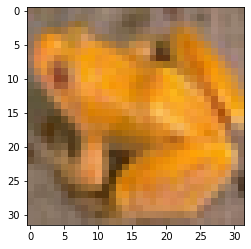

In [40]:
plt.imshow(X_test[random_image])

In [42]:
class_names[np.argmax(predictions[0])]

'deer'